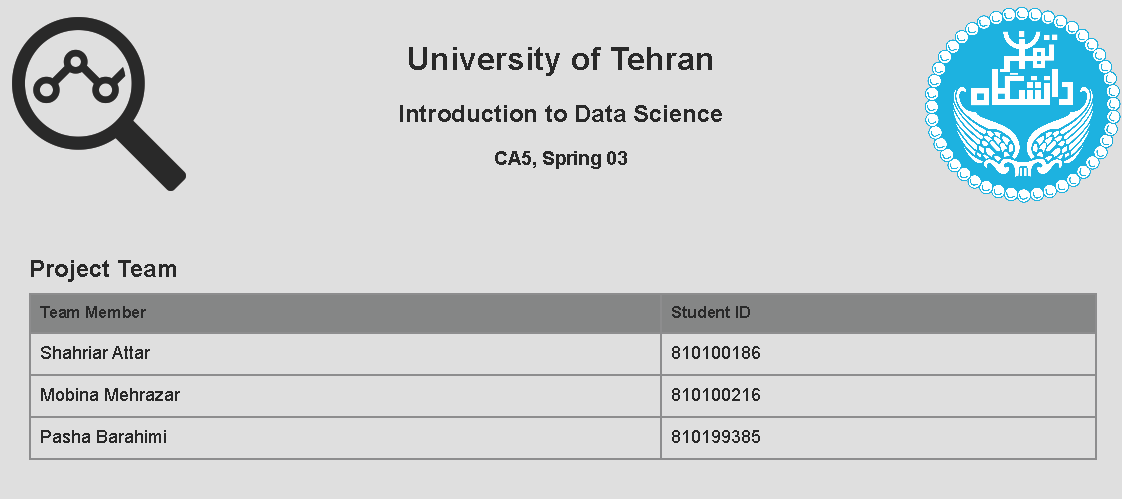

# Feature Engineering Techniques

## Table of Contents

- [Feature Engineering Techniques](#feature-engineering-techniques)
  - [Introduction](#introduction)
  - [Objectives](#objectives)
  - [Dataset Description](#dataset-description)
  - [Tasks](#tasks)
  - [Environment Setup](#environment-setup)
  - [Questions](#questions)
  - [References](#references)


## Introduction

In this assignment, we will apply feature engineering techniques to a football-related dataset with the aim of analyzing the likelihood of scoring a goal through a shot. Following this analysis, we will explore regression and cross-validation concepts in greater depth by implementing multivariate regression and k-fold cross-validation from scratch. These techniques will be applied to a preprocessed dataset related to cars. Lastly, we will compare the results obtained from our custom implementations with those from built-in Python libraries.

## Objectives

This assignment aims to:

- Implementing multivariate regression and k-fold cross-validation from scratch.
- Comparing the results obtained from custom implementations with those from built-in Python libraries.

## Tasks

1. Preprocessing

2. Multivariate Regression Implementation

3. Manual K-Fold Cross Validation Implementation

4. Comparison with Built-in Python Libraries

## Dataset Description

The dataset utilized for preprocessing, named "football.csv", encompasses football-related data, offering insights into various shot attributes, including timing, location (such as corner or penalty), and outcomes like "saved by the goalkeeper", "blocked by defenders", or "missed" shots.

For the implementation phase, a distinct preprocessed dataset, "cars.csv", focusing on automotive data, will be employed. This dataset contains comprehensive information about cars, and our objective is to leverage it to train custom multivariate regression and k-fold models for predicting the "Price in Thousands" and "Horsepower" attributes.

## Environment Setup

Let's begin with setting up the Python environment and importing the necessary libraries.

In [261]:
from typing import Optional

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import mutual_info_classif

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [302]:
FOOTBALL_CSV = "../data/football.csv"
CLEANED_FOOTBALL_CSV = "../data/cleaned_football.csv"
CARS_CSV = "../data/cars.csv"

RANDOM_STATE = 42
RANDOM_STATES = [20, 25, 30]
TEST_SIZE = 0.2
EPOCHS = 100
LEARNING_RATE = 0.01

## Main Tasks

### Preprocessing

First, we will handle cleaning and analyzing the dataset, highlighting its statistical attributes and visualizing its features. Our goal is to identify the beneficial features and justify out conclusions convincingly. Additionally, we should employ feature engineering techniques to refine the dataset, either by removing or replacing less desirable features. To gain a deeper understanding of feature engineering, we'll train an arbitrary but appropriate model and evaluate the outcomes before and after preprocessing. Furthermore, to assess the importance of each feature, we will utilize the mutual information method to create a `pandas` dataframe with two columns: one for features and the other for their importance. Subsequently, we'll sort the dataframe in descending order based on importance and display the results.

Some notes to consider during preprocessing:

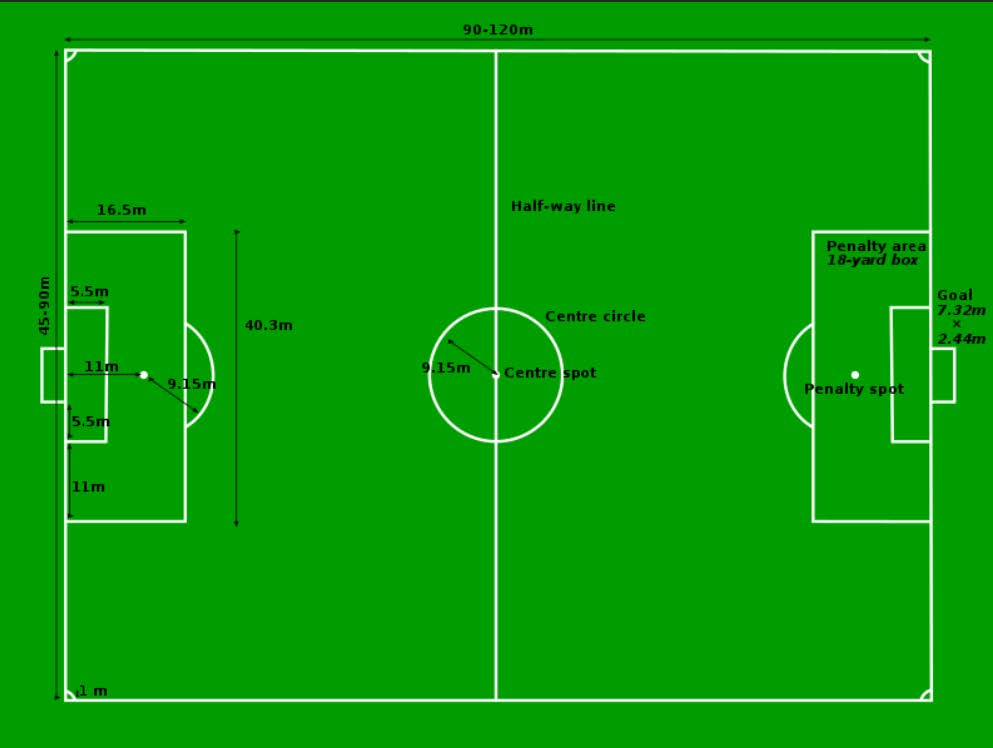

- The above figure shows a football pitch, to gain better insights into the dataset.
- We can apply various methods that we have learned throughout the course to fill missing values and manipulate categorical features in our data.
- We can consolidate similar features. For instance, we could treat "goal" and "own goal" as the same.
- We'll employ feature selection to exclude less significant features, thereby reducing the dimensionality and lowering computational costs.
- For a more thorough analysis, let's consider extracting new, more informative features from existing ones. For instance, we can calculate shot distance and angle using the following formulas and incorporate them into our analysis:

    - $distance = \sqrt{x^2 + y^2}$
    - $angle =$
      - $rad2deg(\arctan(\theta)): if \arctan(\theta) \geq 0$
      - $rad2deg(\arctan(\theta + \pi)): if \arctan(\theta) < 0$
    - Where $\theta = \frac{7.32x}{x^2 + y^2 - (\frac{7.32}{2})^2}$

In [3]:
df = pd.read_csv(FOOTBALL_CSV)

In [4]:
df.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


First, we will check for missing values in the dataset and then proceed with the preprocessing steps.

In [5]:
df.isnull().sum()

matchId                   0
playerId                  0
playType                  0
bodyPart                  0
x                         0
y                         0
interveningOpponents      0
interveningTeammates      0
interferenceOnShooter    34
minute                    0
second                    0
outcome                  34
dtype: int64

Since `outcome` is the target and we cannot fill missing values in the target column, we will drop rows with missing values in the `outcome` column.

In [6]:
df = df.dropna(subset=["outcome"])
df.isnull().sum()

matchId                  0
playerId                 0
playType                 0
bodyPart                 0
x                        0
y                        0
interveningOpponents     0
interveningTeammates     0
interferenceOnShooter    0
minute                   0
second                   0
outcome                  0
dtype: int64

The missing values in `interferenceOnShooter` correspond to the missing values in `outcome`, so no more missing values are present in the dataset.

Now we check for duplicate rows in the dataset and remove them if any are found.

In [7]:
df.duplicated().sum()

0

So everything is fine here. Now we check any outliers in the dataset.

In [8]:
df.describe()

,x,y,interveningOpponents,interveningTeammates,minute,second
count,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000,8891.000000
mean,14.597636,0.371103,2.537735,0.336857,48.540997,29.244517
std,7.834989,9.012600,1.385693,0.680940,26.393372,17.307217
min,0.000000,-33.920000,0.000000,0.000000,0.000000,0.000000
25%,8.480000,-5.740000,2.000000,0.000000,26.000000,14.000000
50%,12.470000,0.500000,2.000000,0.000000,49.000000,29.000000
75%,20.950000,6.730000,3.000000,0.000000,71.000000,44.000000
max,70.820000,33.920000,11.000000,7.000000,98.000000,59.000000


In [9]:
def plot_distributions(df: pd.DataFrame):
    numerical_columns = df.select_dtypes(include=[np.number]).columns

    num_of_rows = (len(numerical_columns) + 1) // 2
    figs, axes = plt.subplots(num_of_rows, 2, figsize=(15, 5 * num_of_rows))

    plt.subplots_adjust(hspace=0.5)
    for i, column in enumerate(numerical_columns):
        ax = axes[i // 2, i % 2]
        ax.hist(df[column], bins=20)
        ax.set_title(f"Distribution of {column}")
        ax.set_xlabel(column)
        ax.set_ylabel("Frequency")

    plt.show()

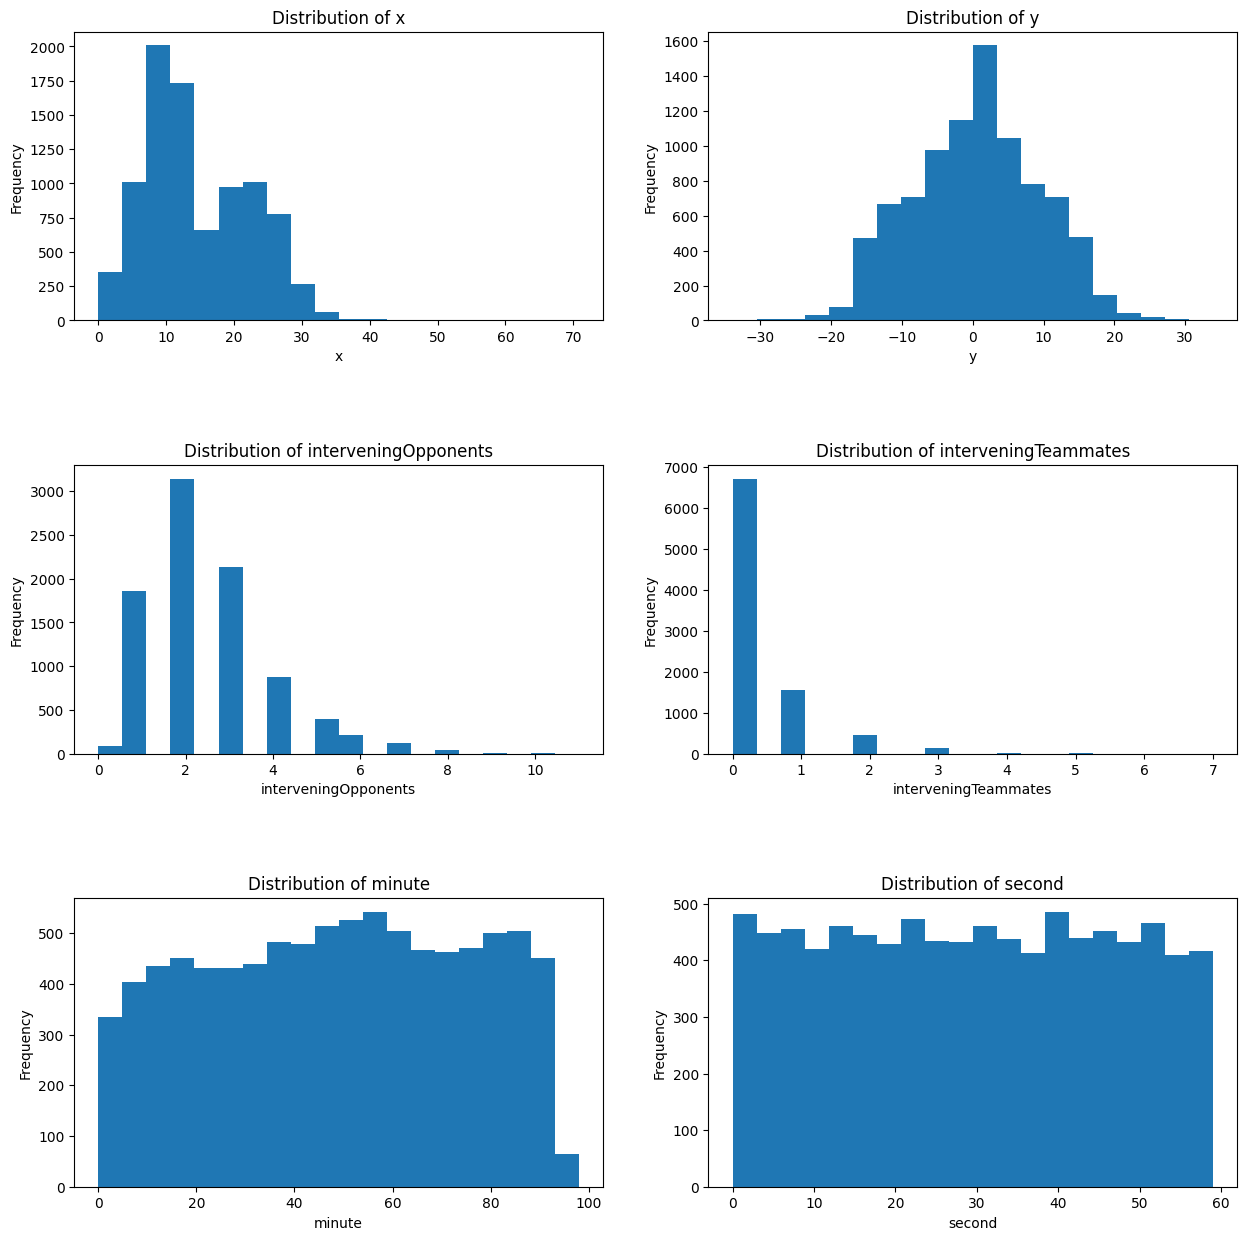

In [10]:
plot_distributions(df)

Now we delete outliers for columns `x`, `y`, `interveningOpponents`, `interveningTeammates`, since they are just rare cases and can be considered as outliers. Also `second` and `minute` columns are not necessary for our analysis, since they have uniform distribution and do not provide any useful information. For `bodyPart` and `playType` columns, we drop any value which amounts to less than 1% of the total data. For `interferenceOnShooter` column, we map the intensity to 0, 1 and 2.

In [11]:
def delete_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(df[column]))
    threshold = 3
    df = df[(z_scores < threshold)]

In [12]:
delete_outliers(df, "x")
delete_outliers(df, "y")
delete_outliers(df, "interveningOpponents")
delete_outliers(df, "interveningTeammates")

In [13]:
df.drop(columns=["second", "minute"], inplace=True)

In [14]:
total_rows = len(df)

bodyPart_counts = df["bodyPart"].value_counts()
playType_counts = df["playType"].value_counts()

bodyPart_to_drop = bodyPart_counts[bodyPart_counts / total_rows < 0.01].index
playType_to_drop = playType_counts[playType_counts / total_rows < 0.01].index

df = df[~df["bodyPart"].isin(bodyPart_to_drop)]
df = df[~df["playType"].isin(playType_to_drop)]

In [15]:
df["interferenceOnShooter"].unique()

array(['medium', 'low', 'high'], dtype=object)

In [16]:
interference_mapping = {
    "low": 0,
    "medium": 1,
    "high": 2
}

df["interferenceOnShooter"] = df["interferenceOnShooter"].map(interference_mapping)

Then we make the `outcome` column binary, where 1 represents a goal and 0 represents a non-goal.

In [17]:
df["outcome"].value_counts()

outcome
missed chance      3460
saved by keeper    2386
blocked shot       1755
goal               1065
hit the post        170
Name: count, dtype: int64

In [25]:
df["outcome"] = df["outcome"].apply(lambda x: 1 if x == "goal" else 0)

And then we delete the `p_` and `m_` before player and match ids respectively, and convert them to integers. 

In [18]:
df["playerId"] = df["playerId"].apply(lambda x: int(x.replace("p_", "")))
df["matchId"] = df["matchId"].apply(lambda x: int(x.replace("m_", "")))

Now we combine two columns of `interveningOpponents` and `interveningTeammates` to `intervening`

In [19]:
df["intervening"] = df["interveningOpponents"] + df["interveningTeammates"]
df.drop(columns=["interveningOpponents", "interveningTeammates"], inplace=True)

Then we encode the categorical columns using one-hot encoding.

In [20]:
df = pd.get_dummies(df, columns=["bodyPart", "playType"])

Now since the id of match and player are not important for us we replace them with a more useful statistic, the conversion rate of the player and the conversion rate of each match.

In [26]:
df_player = df.groupby("playerId")[["outcome"]].mean().reset_index()
df_player.columns = ["playerId", "playerConversionRate"]
df = df.merge(df_player, on="playerId", how="left")
df.drop(columns=["playerId"], inplace=True)

In [27]:
df_match = df.groupby("matchId")[["outcome"]].mean().reset_index()
df_match.columns = ["matchId", "matchConversionRate"]
df = df.merge(df_match, on="matchId", how="left")
df.drop(columns=["matchId"], inplace=True)

Now we replace `x` and `y` with `distance` and `angle` as explained above.

In [28]:
df["distance"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2)
df["angle"] = np.arctan(7.32 * df["x"] / (df["x"] ** 2 + df["y"] ** 2 - (7.32 / 2) ** 2)) # 7.32 is the width of the goal
df["angle"] = np.where(df["angle"] >= 0, np.rad2deg(df["angle"]), np.rad2deg(df["angle"] + np.pi))
df.drop(columns=["x", "y"], inplace=True)

Now we re-order the columns for more clarity.

In [29]:
df = df[[col for col in df.columns if col != "outcome"] + ["outcome"]]

In [30]:
df.head()

,interferenceOnShooter,intervening,bodyPart_head,bodyPart_left foot,bodyPart_right foot,playType_free kick,playType_open play,playType_penalty,playerConversionRate,matchConversionRate,distance,angle,outcome
0,1,1,False,False,True,False,True,False,0.084746,0.121212,17.530810,18.544088,1
1,1,3,False,True,False,False,True,False,0.095238,0.054054,17.090313,13.982592,0
2,0,8,False,True,False,True,False,False,0.080000,0.125000,29.456534,14.153255,0
3,1,5,False,False,True,False,True,False,0.107143,0.083333,26.948560,15.458384,0
4,1,2,False,False,True,False,True,False,0.103448,0.080000,11.932141,31.315918,1


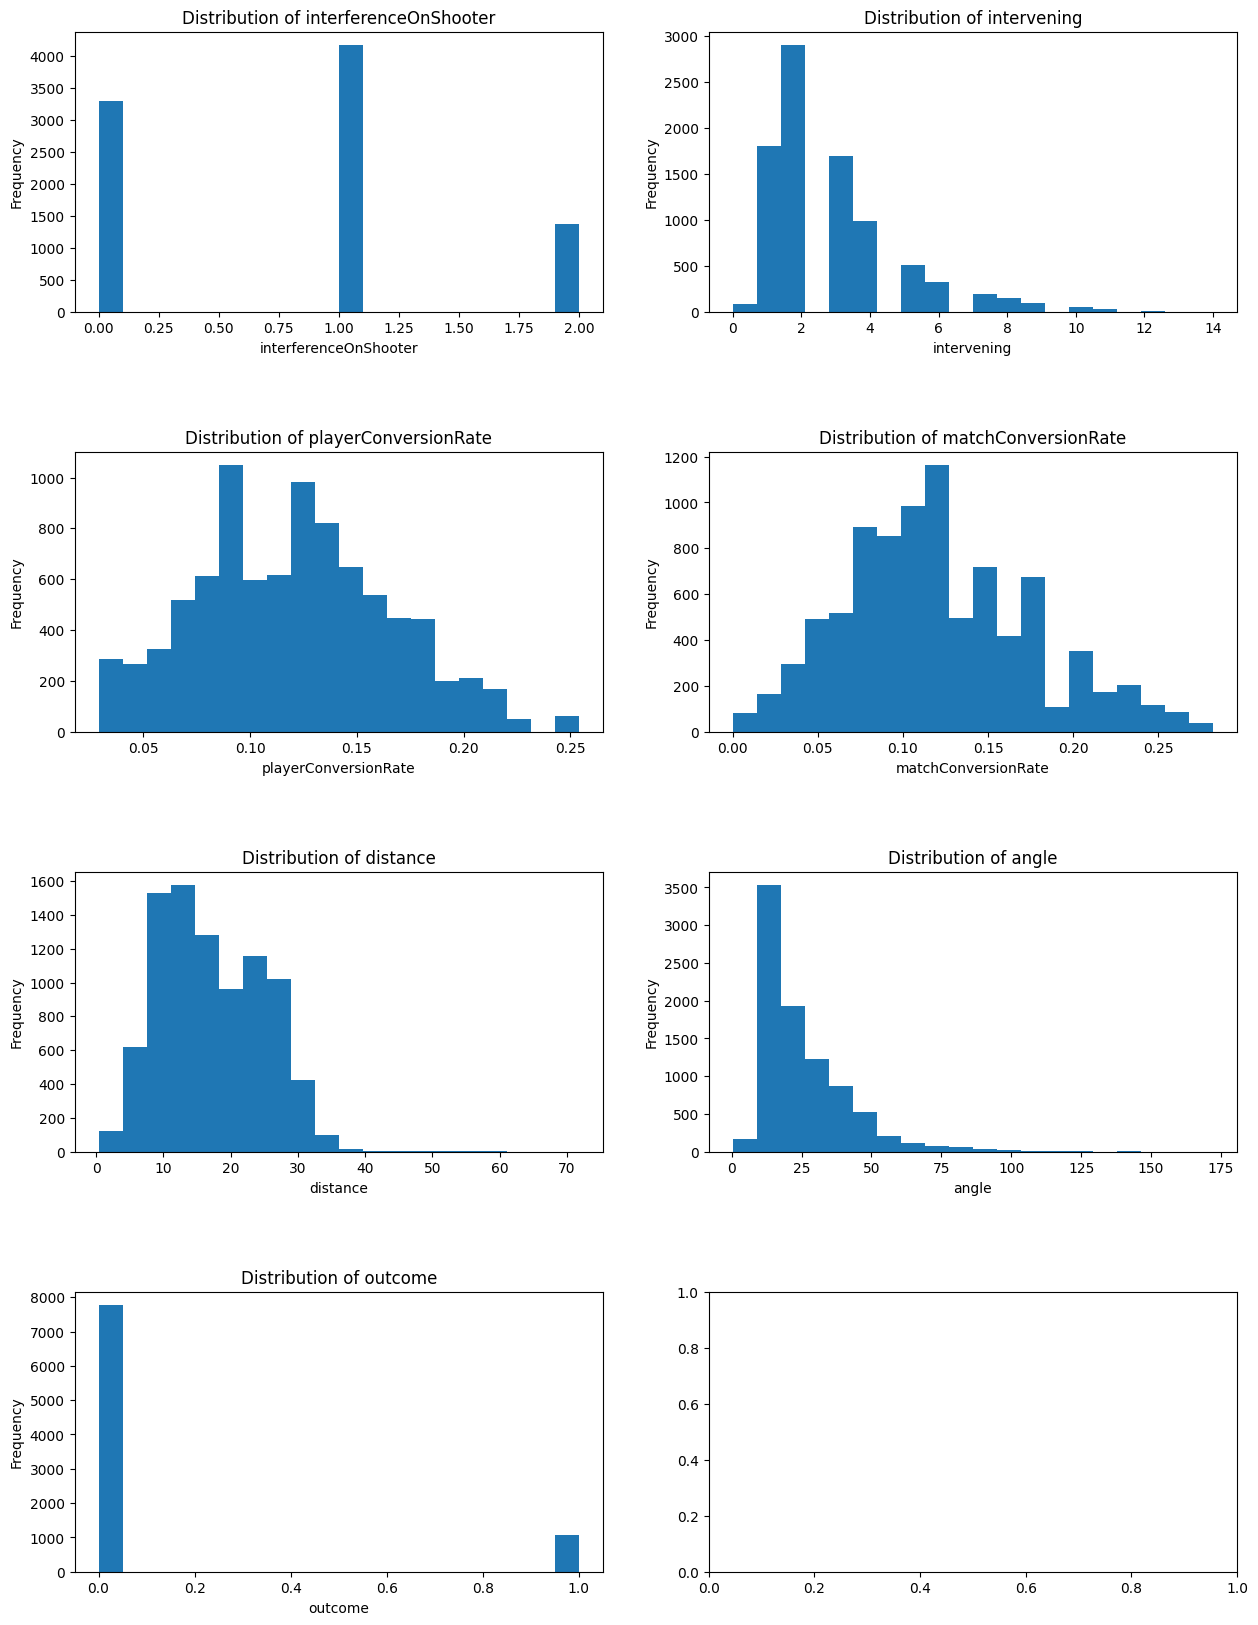

In [31]:
plot_distributions(df)

Then we check their effect on the target column and drop them if they are not significant.

In [32]:
def plot_heatmap(df: pd.DataFrame):
    plt.figure(figsize=(12, 12))
    numerical_columns = df.select_dtypes(include=[np.number]).columns
    sns.heatmap(df[numerical_columns].corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()

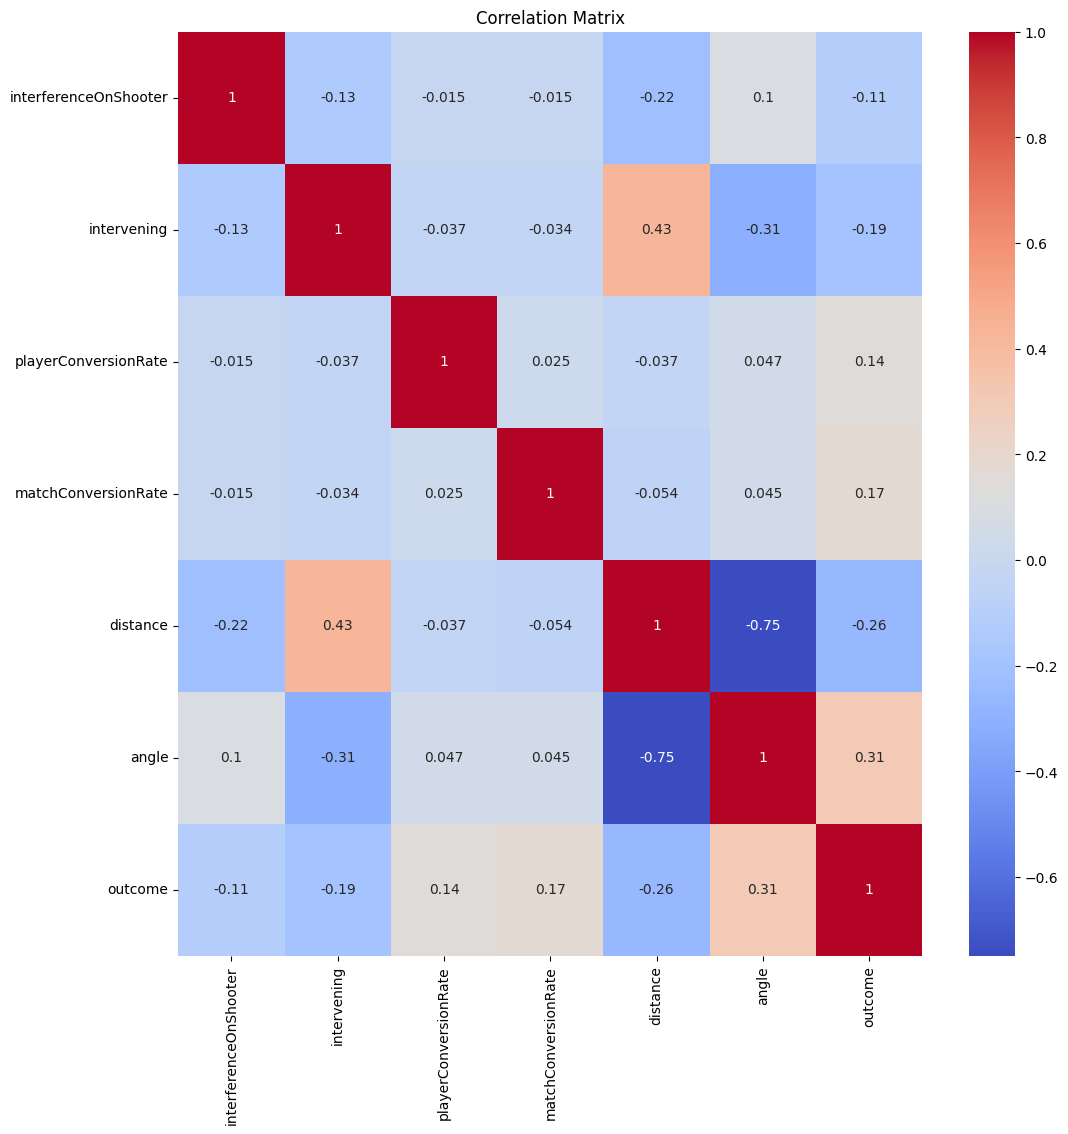

In [33]:
plot_heatmap(df)

In [34]:
correlation = df.drop(columns=["outcome"]).corrwith(df["outcome"])
correlation = pd.DataFrame(correlation)
correlation.columns = ["Correlation"]
correlation.sort_values(by="Correlation", ascending=False, inplace=True, key=abs)
correlation

,Correlation
angle,0.308832
distance,-0.258778
playType_penalty,0.239868
intervening,-0.190891
matchConversionRate,0.169193
playerConversionRate,0.139762
interferenceOnShooter,-0.109180
playType_open play,-0.093433
playType_free kick,-0.028295
bodyPart_left foot,0.013742


We can also use mutual information to check the importance of the features. Mutual information is a measure of the amount of information obtained about one variable through another variable. It is used to determine the importance of a feature in predicting the target variable. We can use the `mutual_info_classif` function from the `sklearn.feature_selection` module to calculate the mutual information between the features and the target variable.

In [35]:
def calc_MI(df: pd.DataFrame) -> pd.DataFrame:
    mi = mutual_info_classif(df.drop(["outcome"], axis=1), df["outcome"], random_state=42)
    mi_df = pd.DataFrame({"Feature": df.drop(["outcome"], axis=1).columns, "Importance": mi})
    mi_df.sort_values(by="Importance", ascending=False, inplace=True)
    mi_df.reset_index(drop=True, inplace=True)
    return mi_df

In [36]:
mi = calc_MI(df)
mi

,Feature,Importance
0,angle,0.058879
1,distance,0.051084
2,intervening,0.038834
3,playType_penalty,0.015231
4,matchConversionRate,0.011400
5,interferenceOnShooter,0.007901
6,playerConversionRate,0.005588
7,playType_open play,0.003925
8,bodyPart_right foot,0.000662
9,bodyPart_head,0.000023


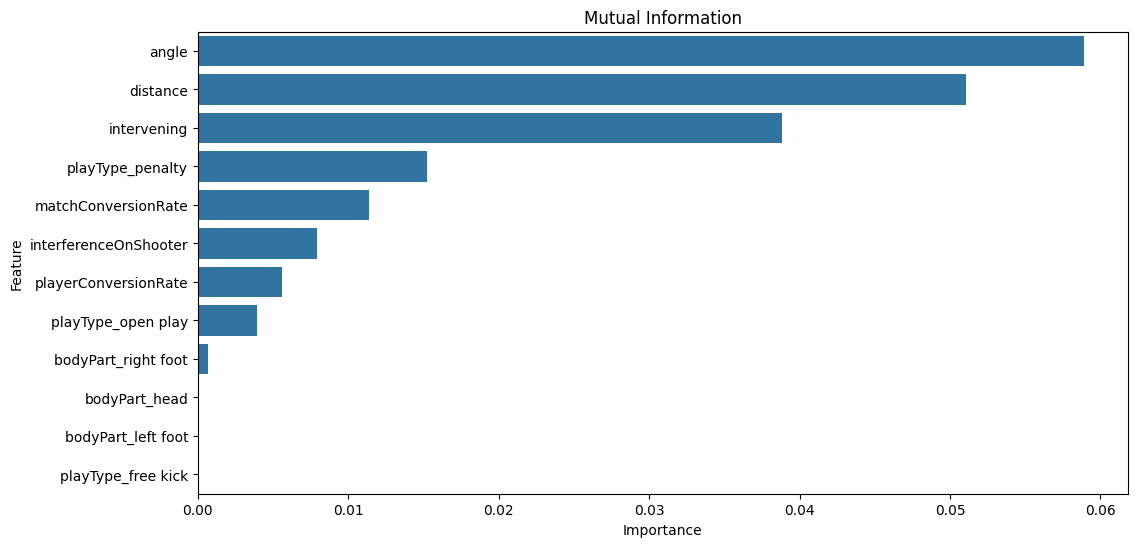

In [37]:
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=mi)
plt.title("Mutual Information")
plt.show()

In [38]:
df.to_csv(CLEANED_FOOTBALL_CSV, index=False)

Now we train a model to anticipate the outcome.

In [39]:
scale = StandardScaler()
X = df.drop(columns=["outcome"])
X = scale.fit_transform(X)
y = df["outcome"]

In [40]:
X_train, X, y_train, y = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [42]:
def create_model(shape: Optional[int] = None) -> keras.Model:
    if shape is None:
        shape = X_train.shape[1]

    model = Sequential([
        Dense(64, input_dim=shape, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [44]:
model = create_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8729 - loss: 0.3904 - val_accuracy: 0.8890 - val_loss: 0.2857
Epoch 2/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8973 - loss: 0.2782 - val_accuracy: 0.8890 - val_loss: 0.2765
Epoch 3/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8964 - loss: 0.2732 - val_accuracy: 0.8890 - val_loss: 0.2787
Epoch 4/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8930 - loss: 0.2766 - val_accuracy: 0.8911 - val_loss: 0.2781
Epoch 5/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8944 - loss: 0.2719 - val_accuracy: 0.8925 - val_loss: 0.2778
Epoch 6/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9017 - loss: 0.2589 - val_accuracy: 0.8904 - val_loss: 0.2760
Epoch 7/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8927 - loss: 0.2724 - val_accuracy: 0.8868 - val_loss: 0.2807
Epoch 8/10
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8998 - loss: 0.2652 - val_accuracy: 0.

In [46]:
loss, accuracy = model.evaluate(X, y)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9067 - loss: 0.2526


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


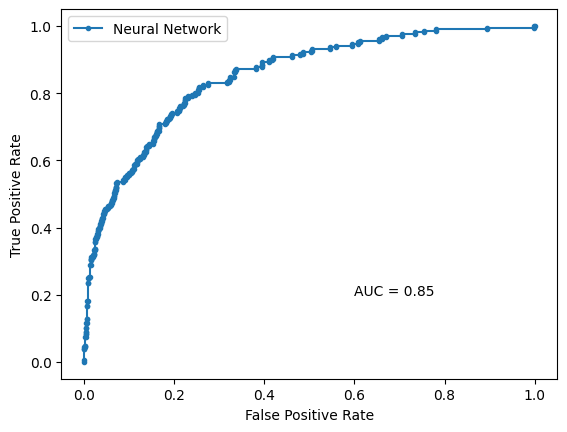

In [47]:
y_pred = model.predict(X)

fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, marker=".", label="Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.text(0.6, 0.2, f"AUC = {roc_auc:.2f}")
plt.show()

To compare the result without feature engineering we train a model on the original dataset.

In [48]:
original_df = pd.read_csv(FOOTBALL_CSV)
original_df = original_df[original_df["outcome"].notnull()]
original_df["outcome"] = original_df["outcome"].apply(lambda x: 1 if x == "goal" else 0)
original_df = pd.get_dummies(original_df, columns=["bodyPart", "playType"])
original_df["playerId"] = original_df["playerId"].apply(lambda x: int(x.replace("p_", "")))
original_df["matchId"] = original_df["matchId"].apply(lambda x: int(x.replace("m_", "")))
original_df["interferenceOnShooter"] = original_df["interferenceOnShooter"].map(interference_mapping)

In [49]:
X_original = original_df.drop(columns=["outcome"])
X_original = np.array(X_original).astype(np.float32)
y_original = original_df["outcome"]
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

In [55]:
model = create_model(X_original_train.shape[1])
model.fit(X_original_train, y_original_train, validation_data=(X_original_test, y_original_test), epochs=10, batch_size=32)

Epoch 1/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8210 - loss: 0.8496 - val_accuracy: 0.8617 - val_loss: 0.3925
Epoch 2/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8722 - loss: 0.3614 - val_accuracy: 0.8803 - val_loss: 0.3840
Epoch 3/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8690 - loss: 0.3655 - val_accuracy: 0.8741 - val_loss: 0.3499
Epoch 4/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8721 - loss: 0.3633 - val_accuracy: 0.8465 - val_loss: 0.3862
Epoch 5/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8575 - loss: 0.3715 - val_accuracy: 0.8808 - val_loss: 0.3452
Epoch 6/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8793 - loss: 0.3360 - val_accuracy: 0.8803 - val_loss: 0.4588
Epoch 7/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8749 - loss: 0.3607 - val_accuracy: 0.8848 - val_loss: 0.3310
Epoch 8/10
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8827 - loss: 0.3239 - val_accuracy: 0.

In [56]:
original_loss, original_accuracy = model.evaluate(X_original_test, y_original_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8658 - loss: 0.3618


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


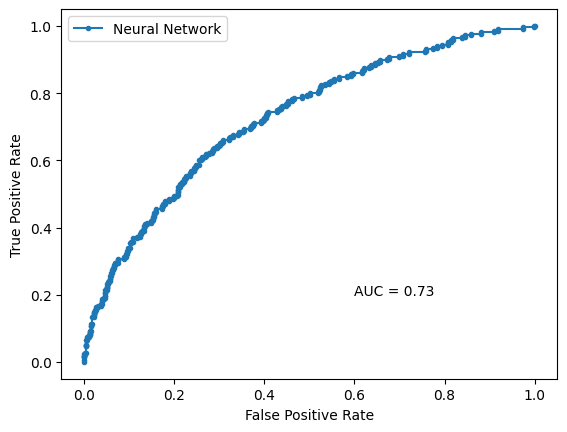

In [57]:
y_original_pred = model.predict(X_original_test)

fpr_original, tpr_original, _ = roc_curve(y_original_test, y_original_pred)
roc_auc_original = auc(fpr_original, tpr_original)
plt.plot(fpr_original, tpr_original, marker=".", label="Neural Network")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.text(0.6, 0.2, f"AUC = {roc_auc_original:.2f}")
plt.show()

In [58]:
stats = [["Loss", loss, original_loss], ["Accuracy", accuracy, original_accuracy], ["AUC", roc_auc, roc_auc_original]]
print(tabulate(stats, headers=["Metric", "Cleaned Data", "Original Data"], tablefmt="pretty"))

+----------+---------------------+---------------------+
|  Metric  |    Cleaned Data     |    Original Data    |
+----------+---------------------+---------------------+
|   Loss   | 0.26335445046424866 | 0.37234827876091003 |
| Accuracy | 0.9032805562019348  | 0.8572231531143188  |
|   AUC    | 0.8503628107298348  | 0.7268423243918398  |
+----------+---------------------+---------------------+


As we can see, the model trained on the preprocessed dataset has a higher accuracy than the model trained on the original dataset. This demonstrates the importance of feature engineering in improving model performance. Also, the model trained on the preprocessed dataset converges faster than the model trained on the original dataset.

### Multivariate Regression Implementation

We'll implement multivariate regression from scratch and use the gradient descent algorithm to update the weights. Then, we'll validate the regression model by providing a visual comparison between the predicted and actual values for "Price in Thousands" and “Horsepower”. Additionally, we'll plot the accuracy across different random states for a more robust verification. Finally, we will display a learning curve to illustrate the progression of the regression process.

In [159]:
df = pd.read_csv(CARS_CSV)
df.head()

,Sales in Thousands,Year Resale Value,Price in Thousands,Engine Size,Horsepower,Wheelbase,Width,Length,Curb Weight,Fuel Capacity,Fuel Efficiency,Power Perf Factor,Vehicle Type Car,Vehicle Type Passenger
0,16.919,16.360,21.500,1.8,140,101.2,67.3,172.4,2.639,13.2,28,58.280150,0,1
1,39.384,19.875,28.400,3.2,225,108.1,70.3,192.9,3.517,17.2,25,91.370778,0,1
2,20.397,22.255,23.990,1.8,150,102.6,68.2,178.0,2.998,16.4,27,62.777639,0,1
3,18.780,23.555,33.950,2.8,200,108.7,76.1,192.0,3.561,18.5,22,84.565105,0,1
4,91.561,12.475,21.975,3.1,175,109.0,72.7,194.6,3.368,17.5,25,71.181451,0,1


Multivariate regression is a technique used to predict the value of multiple dependent variables based on one or more independent variables. The multivariate regression model can be represented as follows:

$Y = XW + \epsilon$

Where:
- $Y$ is a matrix of dependent variables $n\times p$ matrix where $n$ is the number of samples and $p$ is the number of dependent variables.
- $X$ is a matrix of independent variables $n\times (q+1)$ matrix where $n$ is the number of samples and $q$ is the number of independent variables. We add a column of ones to $X$ to account for the bias term.
- $W$ is a $(q+1)\times p$ matrix of weights where $q$ is the number of independent variables and $p$ is the number of dependent variables.
- $\epsilon$ is the error term.

The fitted values can be calculated as follows:

$\hat{Y} = X\hat{W}$

Where:
- $\hat{Y}$ is a $1\times p$ matrix of predicted values.
- $\hat{W}$ is a $(q+1)\times p$ matrix of estimated weights.
- $X$ is a $1\times (q+1)$ matrix of independent variables.

The goal of multivariate regression is to find the best-fitting line that predicts the value of the dependent variables based on the independent variables. For calculating the best-fitting line, we use the gradient descent algorithm to update the weights. The gradient descent algorithm is an optimization algorithm used to minimize the error between the predicted and actual values. The algorithm works by iteratively updating the weights in the direction of the steepest descent of the error function. The weights are updated using the following formula:

$W = W - \alpha \frac{1}{n}X^T(Y - XW)$

Where:
- $W$ is the matrix of weights.
- $\alpha$ is the learning rate.
- $n$ is the number of samples.
- $X$ is the matrix of independent variables.
- $Y$ is the matrix of dependent variables.

The algorithm iteratively updates the weights until the error converges to a minimum value. The learning rate $\alpha$ determines the step size of the weight updates. A larger learning rate can lead to faster convergence but may overshoot the minimum, while a smaller learning rate can lead to slower convergence but more accurate results.

First, let's specify the dependent and independent variables for the regression model. We'll use "Price in Thousands" and "Horsepower" as the dependent variables and other columns as independent variables. We'll also normalize the independent variables to ensure that the gradient descent algorithm converges efficiently.

In [160]:
X = df.drop(columns=["Price in Thousands", "Horsepower"])
y = df[["Price in Thousands", "Horsepower"]]

In [161]:
scale = MinMaxScaler()
X = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [275]:
def compute_gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    m = len(y)
    predictions = X @ theta
    errors = predictions - y
    gradients = X.T @ errors / m
    return gradients

def gradient_descent(X: np.ndarray, y: np.ndarray, learning_rate: float, epochs: int) -> list[np.ndarray]:
    thetas = []
    n = X.shape[1]
    m = y.shape[1]
    theta = np.zeros((n, m))
    for _ in tqdm(range(epochs)):
        gradients = compute_gradient(X, y, theta)
        theta -= learning_rate * gradients
        thetas.append(theta.copy())
    return thetas

In [252]:
def loss(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    m = len(y)
    predictions = X @ theta
    errors = predictions - y
    return np.sum(errors ** 2, axis=0) / (2 * m)

def predict(X: np.ndarray, theta: np.ndarray) -> np.ndarray:
    return X @ theta

def r2_score(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    ss_res = np.sum((y_true - y_pred) ** 2, axis=0)
    ss_tot = np.sum((y_true - np.mean(y_true, axis=0)) ** 2, axis=0)
    return 1 - ss_res / ss_tot

def train(X_train: np.ndarray, y_train: np.ndarray, learning_rate: float, epochs: int) -> list[np.ndarray]:
    X_train = np.c_[np.ones(len(X_train)), X_train]
    y_train = y_train.values
    thetas = gradient_descent(X_train, y_train, learning_rate, epochs)
    return thetas

def evaluate(X: np.ndarray, y: np.ndarray, thetas: list[np.ndarray]) -> tuple:
    X = np.c_[np.ones(len(X)), X]
    losses = np.array([loss(X, y, theta) for theta in thetas])
    predictions = np.array([predict(X, theta) for theta in thetas])
    r2_scores = np.array([r2_score(y, prediction) for prediction in predictions])
    return losses, r2_scores

In [279]:
thetas = train(X_train, y_train, LEARNING_RATE, EPOCHS)
losses_test, r2_scores_test = evaluate(X_test, y_test, thetas)
losses_train, r2_scores_train = evaluate(X_train, y_train, thetas)

100%|██████████| 100/100 [00:00<00:00, 27950.85it/s]


Let's plot the losses:

In [264]:
def plot_per_epoch(train: np.ndarray, test: np.ndarray, ylabel: str, horizontal_lines: list[float] = []):
    price_train = train[:, 0]
    price_test = test[:, 0]
    horsepower_train = train[:, 1]
    horsepower_test = test[:, 1]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(price_train, label="Price in Thousands Train", color="blue")
    plt.plot(price_test, label="Price in Thousands Test", color="orange")
    for line in horizontal_lines:
        plt.axhline(y=line, color="red", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f"Price in Thousands {ylabel} vs Epoch")

    plt.subplot(1, 2, 2)
    plt.plot(horsepower_train, label="Horsepower Train", color="blue")
    plt.plot(horsepower_test, label="Horsepower Test", color="orange")
    for line in horizontal_lines:
        plt.axhline(y=line, color="red", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(f"Horsepower {ylabel} vs Epoch")

    plt.show()


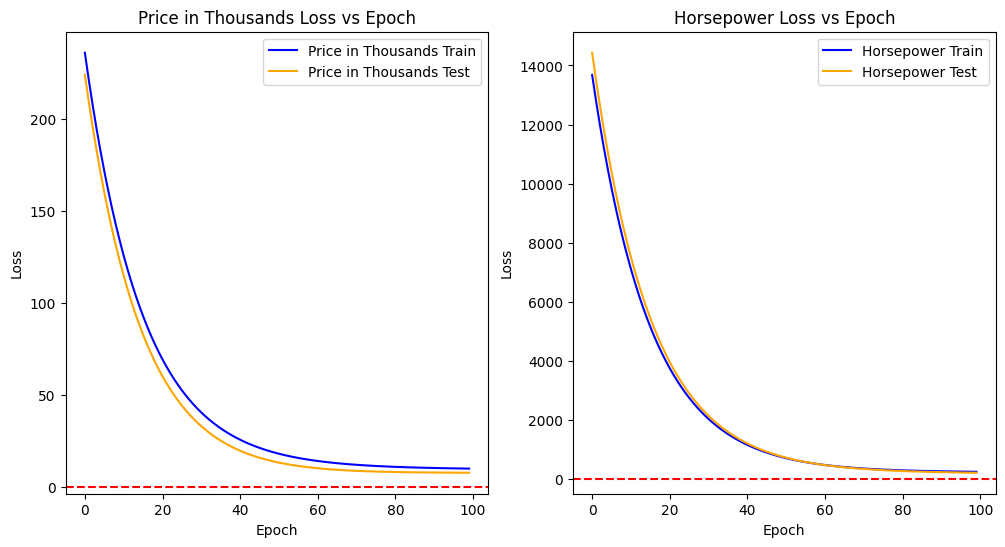

In [280]:
plot_per_epoch(losses_train, losses_test, "Loss", [0])

In [282]:
print(f"Final Loss on Test Data: Price in Thousands = {losses_test[-1][0]:.2f}, Horsepower = {losses_test[-1][1]:.2f}")
print(f"Final Loss on Train Data: Price in Thousands = {losses_train[-1][0]:.2f}, Horsepower = {losses_train[-1][1]:.2f}")

Final Loss on Test Data: Price in Thousands = 7.95, Horsepower = 219.98
Final Loss on Train Data: Price in Thousands = 10.18, Horsepower = 251.84


As we can see, the loss decreases over time, indicating that the model is learning and converging towards the optimal weights.

Now, let's plot the $R^2$ scores:

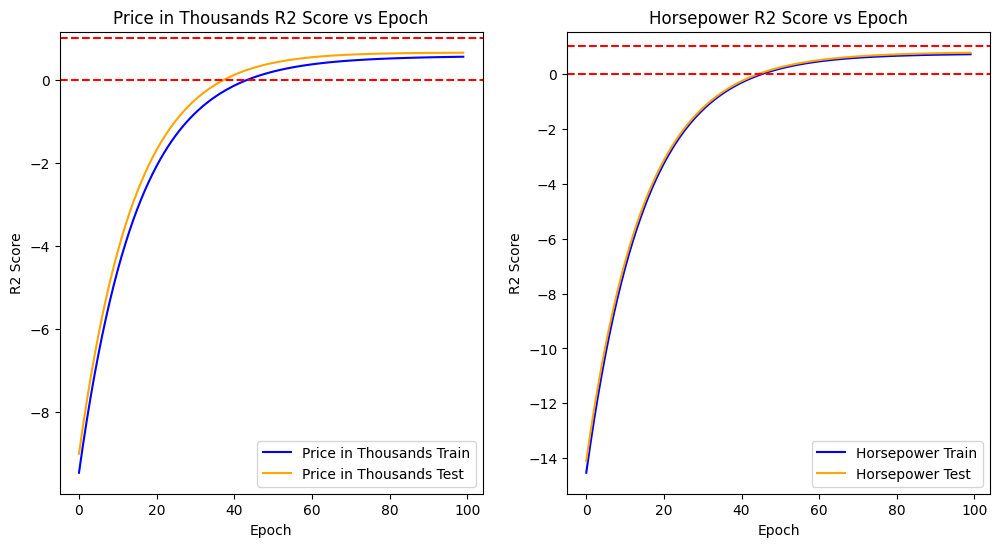

In [283]:
plot_per_epoch(r2_scores_train, r2_scores_test, "R2 Score", [0, 1])

The $R^2$ score is a measure of how well the regression model fits the data. It ranges from 0 to 1, with 1 indicating a perfect fit. However, the $R^2$ score can be negative if the model performs worse than a horizontal line.

In [284]:
print(f"Final R2 Score on Test Data: Price in Thousands = {r2_scores_test[-1][0]:.2f}, Horsepower = {r2_scores_test[-1][1]:.2f}")
print(f"Final R2 Score on Train Data: Price in Thousands = {r2_scores_train[-1][0]:.2f}, Horsepower = {r2_scores_train[-1][1]:.2f}")

Final R2 Score on Test Data: Price in Thousands = 0.65, Horsepower = 0.77
Final R2 Score on Train Data: Price in Thousands = 0.55, Horsepower = 0.71


As we can see, the $R^2$ score increases over time, indicating that the model is improving and fitting the data better.

Finally, let's plot the predicted values against the actual values for "Price in Thousands" and "Horsepower":

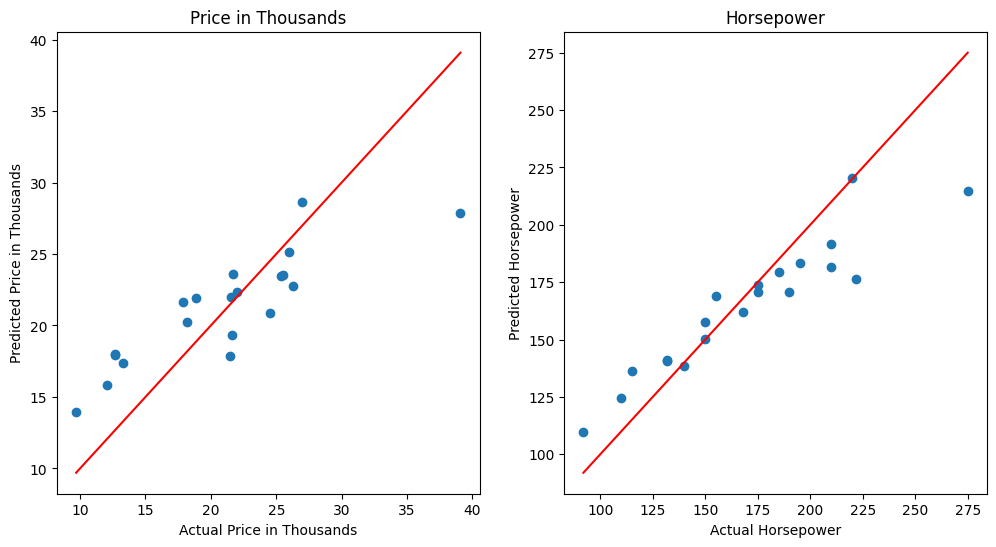

In [285]:
xx = np.c_[np.ones(len(X_test)), X_test]
yy = y_test.values
pred = predict(xx, thetas[-1])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(yy[:, 0], pred[:, 0])
plt.plot([yy[:, 0].min(), yy[:, 0].max()], [yy[:, 0].min(), yy[:, 0].max()], color="red")
plt.xlabel("Actual Price in Thousands")
plt.ylabel("Predicted Price in Thousands")
plt.title("Price in Thousands")

plt.subplot(1, 2, 2)
plt.scatter(yy[:, 1], pred[:, 1])
plt.plot([yy[:, 1].min(), yy[:, 1].max()], [yy[:, 1].min(), yy[:, 1].max()], color="red")
plt.xlabel("Actual Horsepower")
plt.ylabel("Predicted Horsepower")
plt.title("Horsepower")

plt.show()

We can also try with different random states to see how the model performs with different initializations.

In [287]:
def fit(X: np.ndarray, y: np.ndarray, random_state: int) -> dict:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=random_state)
    thetas = train(X_train, y_train, LEARNING_RATE, EPOCHS)
    losses_test, r2_scores_test = evaluate(X_test, y_test, thetas)
    losses_train, r2_scores_train = evaluate(X_train, y_train, thetas)
    return {
        "Price in Thousands": {
            "Loss Test": losses_test[-1][0],
            "R2 Score Test": r2_scores_test[-1][0],
            "Loss Train": losses_train[-1][0],
            "R2 Score Train": r2_scores_train[-1][0]
        },
        "Horsepower": {
            "Loss Test": losses_test[-1][1],
            "R2 Score Test": r2_scores_test[-1][1],
            "Loss Train": losses_train[-1][1],
            "R2 Score Train": r2_scores_train[-1][1]
        }
    }

In [295]:
def print_tabulated_results(res: dict):
    headers = ["Metric", "Price in Thousands", "Horsepower"]
    data = [
        ["Loss Test", f"{res['Price in Thousands']['Loss Test']:.2f}", f"{res['Horsepower']['Loss Test']:.2f}"],
        ["Loss Train", f"{res['Price in Thousands']['Loss Train']:.2f}", f"{res['Horsepower']['Loss Train']:.2f}"],
        ["R2 Score Test", f"{res['Price in Thousands']['R2 Score Test']:.2f}", f"{res['Horsepower']['R2 Score Test']:.2f}"],
        ["R2 Score Train", f"{res['Price in Thousands']['R2 Score Train']:.2f}", f"{res['Horsepower']['R2 Score Train']:.2f}"]
    ]
    print(tabulate(data, headers=headers, tablefmt="pretty"))

In [303]:
results = {}
for state in RANDOM_STATES:
    results[state] = fit(X, y, state)

100%|██████████| 100/100 [00:00<00:00, 33303.99it/s]


In [304]:
for state, res in results.items():
    print(f"Random State: {state}")
    print_tabulated_results(res)
    print()

Random State: 20
+----------------+--------------------+------------+
|     Metric     | Price in Thousands | Horsepower |
+----------------+--------------------+------------+
|   Loss Test    |        7.23        |   283.23   |
|   Loss Train   |       10.43        |   237.26   |
| R2 Score Test  |        0.65        |    0.68    |
| R2 Score Train |        0.54        |    0.74    |
+----------------+--------------------+------------+

Random State: 25
+----------------+--------------------+------------+
|     Metric     | Price in Thousands | Horsepower |
+----------------+--------------------+------------+
|   Loss Test    |       10.53        |   176.34   |
|   Loss Train   |       10.02        |   258.04   |
| R2 Score Test  |        0.50        |    0.73    |
| R2 Score Train |        0.56        |    0.73    |
+----------------+--------------------+------------+

Random State: 30
+----------------+--------------------+------------+
|     Metric     | Price in Thousands | Horsep

The loss and the $R^2$ scores are consistent across different random states, indicating that the model is robust and performs well with different initializations.

### Manual K-Fold Cross Validation Implementation

We'll implement K-Fold cross-validation from scratch. As in the previous section, we will use the gradient descent algorithm to adjust the weights. Then, we would validate your custom K-Fold implementation using statistical metrics. Finally, let's display a learning curve upon completion.

In [ ]:
# code

### Comparison with Built-in Python Libraries

Now, let's compare the results from our custom implementations in sections 2 and 3 with those obtained using built-in Python libraries, and report the findings.

In [ ]:
# code

## Questions

1. **Describe your strategy for addressing challenges such as handling missing values and categorical features. Could you also elaborate on your feature selection metrics and explain the rationale behind them?**  
    Features like second or minute of a goal had a uniform distribution and did not provide any useful information, so they were removed. For the bodyPart and playType columns, any value which amounted to less than 1% of the total data was dropped. The interferenceOnShooter column was mapped to 0, 1, and 2 based on the intensity of interference. The id of the match and player were replaced with the number of goals scored by the player in average and the number of goals scored in a match in average. The x and y columns were replaced with distance and angle, which were calculated using the given formulas. The columns were then reordered for more clarity. The effect of the columns on the target column was checked, and they were dropped if they were not significant.

2. **Why didn’t we use regression to predict whether a shot would result in a goal?**  
   The outcome column was binary, where 1 represented a goal and 0 represented a non-goal. Since the outcome column was binary, it was not suitable for regression. Instead, classification models could be used to predict whether a shot would result in a goal.

3. **How would you go about verifying the accuracy of the given formula used to calculate the shot angle in the preprocessing section?**  
    To verify the accuracy of the formula used to calculate the shot angle, we could compare the calculated angles with known angles for specific shots. We could manually calculate the angles for a few shots using the given formula and compare them with the actual angles. If the calculated angles are close to the actual angles, it would indicate that the formula is accurate. Additionally, we could plot the calculated angles against the actual angles to visualize the relationship and assess the accuracy of the formula. For full mathematical proof you can check out this [link](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760).

1. **Discuss the advantages and disadvantages of k-fold cross-validation. Can you also explain other types of cross-validation methods that could address the limitations and issues associated with k-fold cross-validation?**

2. **What metrics did you use to evaluate your manual implementations of multivariate regression and k-fold cross-validation, and why did you choose them?**



## References

-   [Feature Engineering Tutorial](https://www.explorium.ai/blog/machine-learning/feature-engineering/)
-   [The Geometry of Shooting](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760)
-   [Expected Goal Prediction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10075453/)
-   [Multivariate Regression](https://brilliant.org/wiki/multivariate-regression/)